<b>Importing the libraries

In [55]:
import pandas as pd
import yfinance as yf
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('fivethirtyeight')

<b>Fetching the data from yfinance (S&P 500 and S&P Commodity Index)

In [56]:
ticker = yf.Ticker('^GSPC')
gspc_df = ticker.history(period="10y")
gspc_df.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2012-11-12,1379.859985,1384.869995,1377.189941,1380.030029,2567540000,0,0
2012-11-13,1380.030029,1388.810059,1371.390015,1374.530029,3455550000,0,0
2012-11-14,1374.640015,1380.130005,1352.500000,1355.489990,4109510000,0,0
2012-11-15,1355.410034,1360.619995,1348.050049,1353.329956,3928870000,0,0
2012-11-16,1353.359985,1362.030029,1343.349976,1359.880005,4045910000,0,0


In [57]:
ticker = yf.Ticker('^SPGSCI')
spgsci_df = ticker.history(period="10y")
spgsci_df.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2012-11-12,636.090027,639.679993,633.159973,634.520020,0,0,0
2012-11-13,633.760010,635.169983,629.640015,633.320007,0,0,0
2012-11-14,633.400024,640.159973,632.119995,637.390015,0,0,0
2012-11-15,637.880005,640.380005,630.909973,634.099976,0,0,0
2012-11-16,633.559998,638.030029,631.400024,637.010010,0,0,0


<b>Concatenating the data

In [58]:
df = pd.concat([gspc_df['Close'], spgsci_df['Close']],axis=1)
df.columns = ['Equity','Commodity']
df.head()

,Equity,Commodity
Date,,
2012-11-12,1380.030029,634.520020
2012-11-13,1374.530029,633.320007
2012-11-14,1355.489990,637.390015
2012-11-15,1353.329956,634.099976
2012-11-16,1359.880005,637.010010


<b>Covariance Matrix

In [59]:
cov_matrix = df.pct_change().apply(lambda x: np.log(1+x)).cov()
cov_matrix

,Equity,Commodity
Equity,0.000123,0.000050
Commodity,0.000050,0.000193


<b>Correlation Matrix

In [60]:
corr_matrix = df.pct_change().apply(lambda x: np.log(1+x)).corr()
corr_matrix

,Equity,Commodity
Equity,1.000000,0.321919
Commodity,0.321919,1.000000


<b>Assuming weights and calculating portfolio variance

In [61]:
w = {'Equity': 0.75, 'Commodity': 0.25}
port_var = cov_matrix.mul(w, axis=0).mul(w, axis=1).sum().sum()
port_var

9.971594259491348e-05

<b>Individual Returns (resampled to yearly)

In [62]:
ind_ret = df.resample('Y').last().pct_change().mean()
ind_ret

Equity       0.118022
Commodity    0.022969
dtype: float64

<b>Portfolio Returns

In [63]:
w = [0.75, 0.25]
port_ret = (w*ind_ret).sum()
port_ret

0.09425883244295212

<b>Annual Standard Deviation (Volatility)

In [64]:
ann_sd = df.pct_change().apply(lambda x: np.log(1+x)).std().apply(lambda x: x*np.sqrt(252))
ann_sd

Equity       0.175870
Commodity    0.220705
dtype: float64

<b>Concatenating returns and volatility

In [65]:
assets = pd.concat([ind_ret, ann_sd], axis=1)
assets.columns = ['Returns', 'Volatility']
assets

,Returns,Volatility
Equity,0.118022,0.175870
Commodity,0.022969,0.220705


<b>Defining portfolio parameters and 10000 portfolios for simulation

In [66]:
p_ret = []
p_vol = [] 
p_weights = [] 

num_assets = len(df.columns)
num_portfolios = 10000

<b>Setting random weights, setting the sum to 1 and calculating portfolio return and volatility

In [67]:
for portfolio in range(num_portfolios):
    weights = np.random.random(num_assets)
    weights = weights/np.sum(weights)
    p_weights.append(weights)
    
    returns = np.dot(weights, ind_ret) 
    p_ret.append(returns)
    
    var = cov_matrix.mul(weights, axis=0).mul(weights, axis=1).sum().sum()
    sd = np.sqrt(var) 
    ann_sd = sd*np.sqrt(252)
    p_vol.append(ann_sd)

<b>Defining the portfolio dataframe

In [68]:
data = {'Returns':p_ret, 'Volatility':p_vol}

for counter, symbol in enumerate(df.columns.tolist()):
    data[symbol+' weight'] = [w[counter] for w in p_weights]

In [69]:
portfolios  = pd.DataFrame(data)
portfolios.head()

,Returns,Volatility,Equity weight,Commodity weight
0,0.090004,0.157514,0.705233,0.294767
1,0.071062,0.161412,0.505959,0.494041
2,0.059699,0.169949,0.386414,0.613586
3,0.055786,0.173834,0.345245,0.654755
4,0.090943,0.157677,0.715120,0.284880


<b>Defining a minimum volatility portfolio

In [70]:
min_vol_port = portfolios.iloc[portfolios['Volatility'].idxmin()]
min_vol_port

Returns             0.085960
Volatility          0.157199
Equity weight       0.662690
Commodity weight    0.337310
Name: 2416, dtype: float64

<b>Defining a optimal risky portfolio

In [71]:
rf = 0.0431
optimal_risky_port = portfolios.iloc[((portfolios['Returns']-rf)/(portfolios['Volatility'])).idxmax()]
optimal_risky_port

Returns             0.118000
Volatility          0.175846
Equity weight       0.999769
Commodity weight    0.000231
Name: 2950, dtype: float64

<b>Plotting efficient frontier with the 2 portfolios

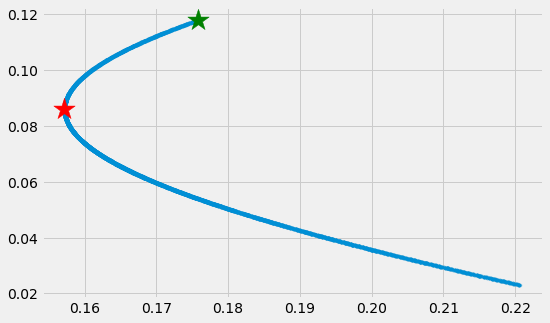

In [72]:
plt.subplots(figsize=(8, 5))
plt.scatter(portfolios['Volatility'], portfolios['Returns'],marker='o', s=10, alpha=0.3)
plt.scatter(min_vol_port[1], min_vol_port[0], color='r', marker='*', s=500)
plt.scatter(optimal_risky_port[1], optimal_risky_port[0], color='g', marker='*', s=500)